# Proyecto de Consolidación 5

**El código de este notebook es igual que el de Aprendizaje por Refuerzo aplicado a Trading que se explicó en clase.**

El objetivo ahora es extender este código para que tenga en cuenta lo siguiente:

- En el código de partida, el agente tiene dos acciones posibles cada día: comprar un paquete de acciones (buy) o vender un paquete de acciones (sell). En esta implementación, el reward total de la estrategia que sea "comprar siempre" es igual que el de una estrategia que sea "vender siempre": cero. Esto se debe a que los rewards en la implementación se calculan solo cuando se vende. Modifica el código para que cuando el agente llegue al final de la partida (**done=True**) se vendan todos los paquetes de acciones que tenga en su cartera (inventory) al precio de mercado en ese momento.

- Introduce un límite al tamaño de cartera (inventory) del agente, haciendo que este sea 5 (no puede tener más de 5 paquetes en su cartera). Por otra parte, amplía la información del estado S del agente para que incluya, además, el número de acciones que tiene en cartera (dividido entre 5, para que vaya entre 0 y 1). Para hacer esto último, modifica la definición de reset y step para que extiendan con este valor el array de salida que devuelven.

- Introduce una tercera acción que sea "Mantener", es decir, ni comprar ni vender. Cambia el esquema de rewards para dar un reward negativo al agente cuando intente vender, si la cartera (inventory) está vacía. Comprueba que efectivamente, una vez ha aprendido, el agente nunca trata de vender cuando su cartera está vacía.

#### Aprendizaje por refuerzo para trading

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.optimizers import Adam

import numpy as np
import pandas as pd
import random
from collections import deque
import os

import matplotlib.pyplot as plt
from urllib.request import urlretrieve
from tqdm import tqdm

# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.makedirs("data", exist_ok=True)
os.makedirs("drive/MyDrive/PC5/models", exist_ok=True)
urlretrieve("https://drive.google.com/uc?export=download&id=1u0BzRR6Sxv-2vUvwEuH-yKYjAFnTE0PC",
            "data/GSPC_2001-10.csv")
urlretrieve("https://drive.google.com/uc?export=download&id=1BPxsLWU6mBkZOpJ0hDYCqp4qj0_N2hjD",
            "data/GSPC_2011.csv");

In [ ]:
df = pd.read_csv("data/GSPC_2001-10.csv")
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,1320.280029,1320.280029,1276.050049,1283.270020,1283.270020,1129400000
1,2001-01-03,1283.270020,1347.760010,1274.619995,1347.560059,1347.560059,1880700000
2,2001-01-04,1347.560059,1350.239990,1329.140015,1333.339966,1333.339966,2131000000
3,2001-01-05,1333.339966,1334.770020,1294.949951,1298.349976,1298.349976,1430800000
4,2001-01-08,1298.349976,1298.349976,1276.290039,1295.859985,1295.859985,1115500000
5,2001-01-09,1295.859985,1311.719971,1295.140015,1300.800049,1300.800049,1191300000
6,2001-01-10,1300.800049,1313.760010,1287.280029,1313.270020,1313.270020,1296500000
7,2001-01-11,1313.270020,1332.189941,1309.719971,1326.819946,1326.819946,1411200000
8,2001-01-12,1326.819946,1333.209961,1311.589966,1318.550049,1318.550049,1276000000
9,2001-01-16,1318.319946,1327.810059,1313.329956,1326.650024,1326.650024,1205700000


In [ ]:
!ls data

GSPC_2001-10.csv  GSPC_2011.csv


In [ ]:
# prints formatted price
def formatPrice(n):
    return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

# returns the vector containing stock data from a fixed file
def getStockDataVec(key):
    vec = []
    lines = open("data/" + key + ".csv", "r").read().splitlines()

    for line in lines[1:]:
        vec.append(float(line.split(",")[4])/1000)

    return vec

# returns an an n-day state representation ending at time t
# Estado: ventana que contiene la evolución de la serie financiera los últimos días
def getState(data, t, window_size):
    # primero genero un bloque de n+1 observaciones incluida el día actual:
    d = max(t-window_size, 0)
    block = data[d:t+1]
    l = len(block)
    if l<(window_size+1):
        block = (window_size+1 - l)*[data[0]] + block # padding con data[t0]

    # Rendimientos logarítmicos:
    res = np.log(np.divide(block[1:], block[:-1])) # log ( x(t) / x(t-1))
    # log(x(1)/x(0)) + log(x(2)/x(1)) + log(x(3)/x(2)) = log(x(3)/x(0))
    # ya que log(A) + log(B) = log(A*B)
    #
    return np.expand_dims(res, axis=0)

In [ ]:
# para mí una partida en training es volver al 2 de enero de 2001 y hacer trading,
# día a día, hasta diciembre de 2010

class Env:
    def __init__(self, stock_name, window_size):
        self.data = getStockDataVec(stock_name) # leo datos de fichero
        self.final_t = len(self.data) - 1
        self.window_size = window_size
        self.reset()

    def reset(self):
        #self.state = getState(self.data, 0, window_size + 1)
        base_state = getState(self.data, 0, window_size)
        self.inventory = [] # lista de acciones compradas. Cada día solo puedo comprar 1. Esta lista contiene los precios de compra de cada acción
        # Paquete de acciones más antiguo: self.inventory[0]. El más reciente: self.inventory[-1]
        inv_ratio = len(self.inventory)/5
        self.state = np.concatenate([base_state, np.array([[inv_ratio]])], axis=1)
        self.t = 0
        return self.state

    def step(self, action):
        # This is how the agent will interact with the environment
        # ACTUALIZADO: Comisiones añadidas para incentivar HOLD estratégico
        reward = 0
        commission = 0.002  # Comisión del 0.2% por transacción (~realista)

        if action==0: # buy
          if len(self.inventory) < 5:
              precio_hoy = self.data[self.t]
              self.inventory.append(precio_hoy)
              reward = -commission  # Costo de transacción al comprar
              #print("Buy:", formatPrice(self.data[self.t]))
          # Si inventario lleno, no hace nada (reward = 0)

        elif action==1: # sell
            if len(self.inventory)>0:
                bought_price = self.inventory.pop(0)
                precio_hoy = self.data[self.t]
                raw_profit = precio_hoy - bought_price
                reward = raw_profit - commission  # Profit menos comisión de venta
                #print("Sell: {} | Profit: {}".format(formatPrice(self.data[self.t]),
                #                                     formatPrice(reward)))
            else:
                # Penalización REDUCIDA: de -1.0 a -0.01
                # Evita que el agente tenga miedo extremo a vender
                reward = -0.01

        elif action==2: # hold
            # Neutro: ni gana ni pierde
            # Ahora es competitivo vs BUY/SELL innecesarios con comisiones
            reward = 0

        done = (self.t == self.final_t-1)
        # Liquidación de inventario al final del episodio
        if done and len(self.inventory) > 0:
            precio_hoy = self.data[self.t]
            reward += sum(precio_hoy - precio_compra for precio_compra in self.inventory)
            self.inventory.clear()

        # estado siguiente:
        #S_ = getState(self.data, self.t+1, self.window_size+1)
        S_base = getState(self.data, self.t+1, self.window_size)
        inv_ratio = len(self.inventory)/5
        S_ = np.concatenate([S_base, np.array([[inv_ratio]])], axis=1)
        self.state = S_
        self.t += 1
        return S_, reward, done


In [ ]:
class Agent:
    def __init__(self, model, is_eval=False, gamma=0.95, epsilon_ini=1.,
                 epsilon_min=0.01, epsilon_decay=0.995, lr=0.001, memsize=1000):

        if type(model) == str:
            model = load_model(model)
        self.model = model
        self.state_size = self.model.input_shape[-1]
        self.action_size = self.model.output_shape[-1]
        self.memory = deque(maxlen=memsize)
        self.inventory = []
        self.is_eval = is_eval

        self.gamma = gamma
        self.epsilon = epsilon_ini
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

    def choose_action(self, state):
        if not self.is_eval and np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)

        Qs = self.model.predict(state, verbose=0)[0]
        return np.argmax(Qs)

    def expReplay_no_optimo(self, batch_size):
        mini_batch = []
        L = len(self.memory)
        for i in range(L-batch_size+1, L):
            mini_batch.append(self.memory[i])

        for state, action, reward, next_state, done in mini_batch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state, verbose=0)[0])

            target_f = self.model.predict(state, state=0)
            target_f[0][action] = target
            self.model.fit(state, target_f, wpochs=1, verbose=0)

    def get_batch(self, model, batch_size=10): # misma función anterior pero mucho más eficiente

        #How many experiences do we have?
        len_memory = len(self.memory)

        #We want to return an input and target vector with inputs from an observed state...
        inputs  = np.zeros((min(len_memory, batch_size), self.state_size))
        inputs2 = np.zeros(inputs.shape)

        #...and the target r + gamma * max Q(s’,a’)
        #Note that our target is a matrix, with possible fields not only for the action taken but also
        #for the other possible actions. The actions not take the same value as the prediction to not affect them

        actions = []
        rewards = []
        dones   = []

        #We draw states to learn from randomly:
        for i, idx in enumerate(np.random.randint(0, len_memory, size=len(inputs))):
            state, action, reward, next_state, done = self.memory[idx]
            inputs[i:(i+1)]  = state
            inputs2[i:(i+1)] = next_state
            actions.append(action)
            rewards.append(reward)
            dones.append(done)

        targets = model.predict(inputs, verbose=0)
        max_next_Qs = np.max(model.predict(inputs2, verbose=0), axis=1)

        for i, (action, reward, done, Q_sa) in enumerate(zip(actions, rewards, dones, max_next_Qs)):
            if done:
                targets[i, action] = reward
            else:
                targets[i, action] = reward + self.gamma*Q_sa

        return inputs, targets


    def expReplay(self, batch_size):
        inputs, targets = self.get_batch(self.model, batch_size=batch_size)

        # train model on experiences
        batch_loss = self.model.train_on_batch(inputs, targets)
        return batch_loss

In [ ]:
stock_name = "GSPC_2001-10"
episode_count = 200  # Aumentado de 20 a 100 para mejor aprendizaje

In [ ]:
# Red neuronal densa:

window_size = 10
model = Sequential()
model.add(Dense(units=8, input_dim=window_size+1, activation="relu"))
model.add(Dense(3))
model.compile(loss="mse", optimizer=Adam(learning_rate=0.001))

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 8)              │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123 (492.00 B)

 Trainable params: 123 (492.00 B)

 Non-trainable params: 0 (0.00 B)

Tenemos una ventana de 10, que son los días o estados que revisamos con la función log  +  la nueva variable que es el ratio de 0 a 1 para el nivel de inventario que tenemos (empty - full)

Rendimientos logarítmicos (window_size valores): [log(x_t/x_{t-1}), log(x_{t-1}/x_{t-2}), ..., log(x_{t-window_size+1}/x_{t-window_size})].
Ratio de inventario (1 valor): len(self.inventory)/5 en [0, 1].

Con window_size = 10, +1 variable state de ratio inventario son 11 variables de entrada en total

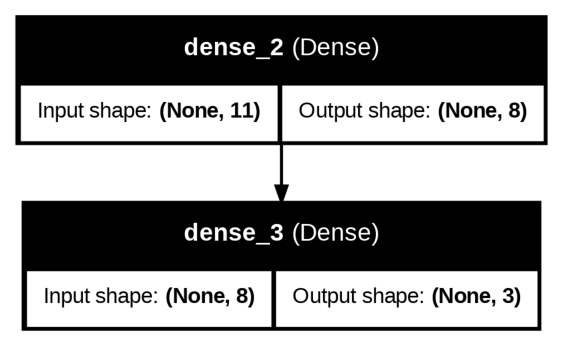

In [ ]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file="img.png")
plt.figure(figsize=(7,7))
plt.imshow(plt.imread("img.png"), aspect="equal"); plt.xticks([]); plt.yticks([]); plt.axis("off");

In [ ]:
agent = Agent(model, memsize=1000, epsilon_ini=1, epsilon_decay=0.99, epsilon_min=0.05)
batch_size = 32
#batch_size = 1024
#batch_size = 128 # con cuántas experiencias de las 1000 que tiene la memoria reentreno la red
training_ratio = 64
environment = Env(stock_name, window_size)

In [ ]:
# Análisis de la nueva configuración de epsilon
import math

print("="*70)
print(" CONFIGURACIÓN DE EXPLORACIÓN-EXPLOTACIÓN")
print("="*70)
print(f"Epsilon inicial: {agent.epsilon:.3f}")
print(f"Epsilon mínimo: {agent.epsilon_min:.3f}")
print(f"Decay rate: {agent.epsilon_decay:.3f}")
print()

# Calcular episodios necesarios para llegar a epsilon_min
n_episodios = math.log(agent.epsilon_min / agent.epsilon) / math.log(agent.epsilon_decay)
print(f"Episodios para llegar a ε_min ({agent.epsilon_min}): {n_episodios:.0f}")
print()

# Mostrar progreso en diferentes puntos
print("Evolución de epsilon:")
print("-" * 70)
for ep in [0, 10, 20, 50, 100, 150, 200, int(n_episodios)]:
    if ep <= n_episodios:
        eps = agent.epsilon * (agent.epsilon_decay ** ep)
        print(f"  Episodio {ep:4d}: ε = {eps:.4f}")
print("="*70)
print(f"💡 Con {episode_count} episodios, epsilon llegará a: {agent.epsilon * (agent.epsilon_decay ** episode_count):.4f}")
print("="*70)


 CONFIGURACIÓN DE EXPLORACIÓN-EXPLOTACIÓN
Epsilon inicial: 1.000
Epsilon mínimo: 0.050
Decay rate: 0.990

Episodios para llegar a ε_min (0.05): 298

Evolución de epsilon:
----------------------------------------------------------------------
  Episodio    0: ε = 1.0000
  Episodio   10: ε = 0.9044
  Episodio   20: ε = 0.8179
  Episodio   50: ε = 0.6050
  Episodio  100: ε = 0.3660
  Episodio  150: ε = 0.2215
  Episodio  200: ε = 0.1340
  Episodio  298: ε = 0.0500
💡 Con 200 episodios, epsilon llegará a: 0.1340


In [ ]:
total_profits = []
for e in range(episode_count + 1):
    total_profit = 0
    state = environment.reset()

    done = False
    counter = 0
    while not done:
        action = agent.choose_action(state)
        next_state, reward, done = environment.step(action)
        total_profit += reward

        agent.memory.append((state, action, reward, next_state, done)) # remember del notebook catch
        state = next_state

        counter += 1
        if (len(agent.memory) > batch_size) and ((counter % training_ratio) == 0):
            print("Realizando expReplay de época", e, ", counter=", counter)
            batch_loss = agent.expReplay(batch_size) # reentreno la red una época usando el batch de experiencias
            print("Batch size: {}, loss: {}".format(batch_size, batch_loss))

    total_profits.append(total_profit)

    #print("Agent memory:", len(agent.memory), "Batch_size:", batch_size)


    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay

    if e % 1 == 0:
        print("Episode {}/{}".format(e, episode_count))
        print("--------------------------------")
        print("Total Profit:", formatPrice(total_profit))
        print("--------------------------------")
        print("   Epsilon:", agent.epsilon)

        # Guardar modelo cada 10 episodios y al final
        if e % 10 == 0 or e == episode_count:
            model_name = f"model_ep{e:03d}"
            agent.model.save(f"drive/MyDrive/PC5/models/{model_name}.keras")
            print(f"💾 Modelo guardado: {model_name}.keras")

# Mostrar resumen final
print("\n" + "="*70)
print("🎉 ENTRENAMIENTO COMPLETADO")
print("="*70)
print(f"Total de episodios: {episode_count + 1}")
print(f"Epsilon final: {agent.epsilon:.4f}")
print(f"Profit promedio: ${np.mean(total_profits):.2f}")
print(f"Mejor episodio: {total_profits.index(max(total_profits))} con ${max(total_profits):.2f}")
print(f"Peor episodio: {total_profits.index(min(total_profits))} con ${min(total_profits):.2f}")
print("="*70)

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Total Profit: -$3.72
--------------------------------
   Epsilon: 0.24241664604458016
💾 Modelo guardado: model_ep140.keras
Realizando expReplay de época 141 , counter= 64
Batch size: 32, loss: 0.00018032004300039262
Realizando expReplay de época 141 , counter= 128
Batch size: 32, loss: 0.0001802990591386333
Realizando expReplay de época 141 , counter= 192
Batch size: 32, loss: 0.00018030450155492872
Realizando expReplay de época 141 , counter= 256
Batch size: 32, loss: 0.0001803215272957459
Realizando expReplay de época 141 , counter= 320
Batch size: 32, loss: 0.0001803603518055752
Realizando expReplay de época 141 , counter= 384
Batch size: 32, loss: 0.00018034144886769354
Realizando expReplay de época 141 , counter= 448
Batch size: 32, loss: 0.00018031899526249617
Realizando expReplay de época 141 , counter= 512
Batch size: 32, loss: 0.00018033529340755194
Realizando expReplay de época 141 , counter= 576
Batch size: 3

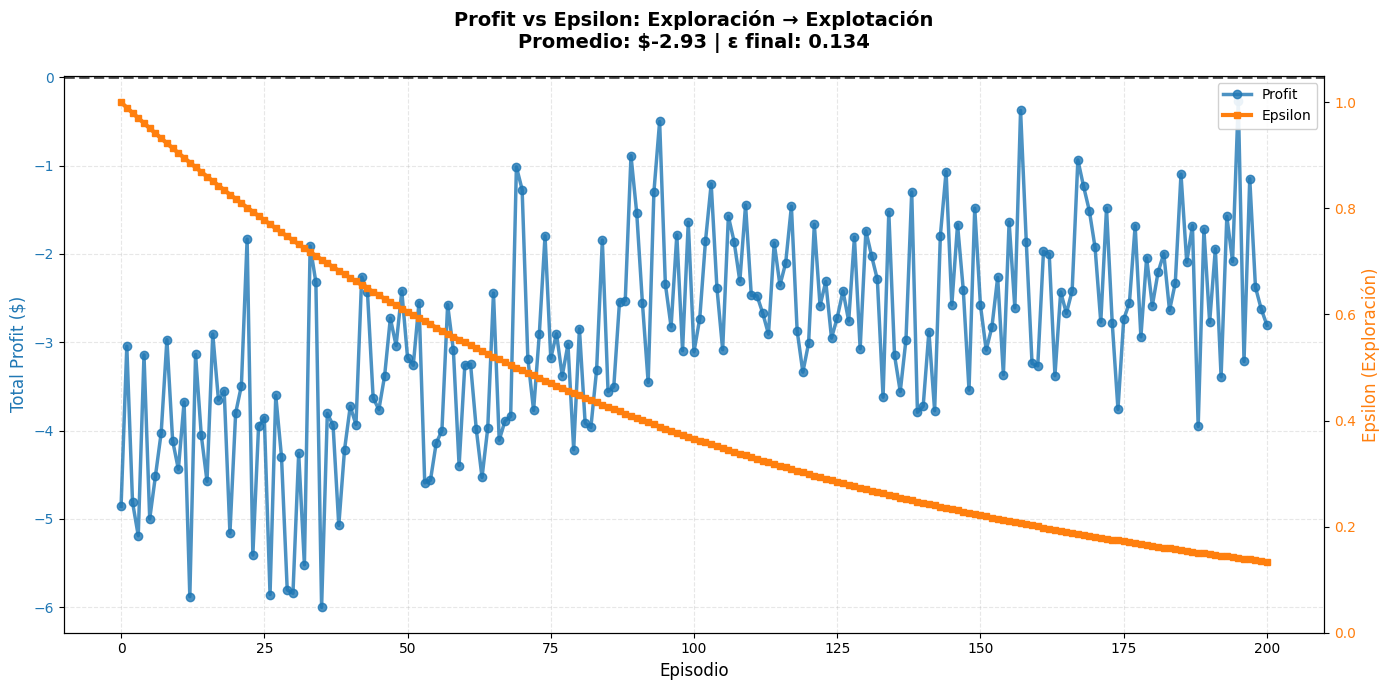


 ANÁLISIS: EXPLORACIÓN vs EXPLOTACIÓN
Epsilon inicial (episodio 0): 1.000
Epsilon final (episodio 200): 0.134
Decay aplicado: 0.866

Profit promedio (primeros 5): $-4.21
Profit promedio (últimos 5): $-2.43
Mejora: $1.77

Profit mínimo: $-6.00 (episodio 35)
Profit máximo: $-0.27 (episodio 195)



In [ ]:
# NUEVA CELDA: Visualización Profit vs Epsilon (monitoreo del aprendizaje)
# Justificación: Añadir gráfico de análisis post-entrenamiento sin modificar celda de training

# MOD: Añadimos gráfico de doble eje para ver relación exploración-explotación
fig, ax1 = plt.subplots(figsize=(14, 7))

# Eje izquierdo: Profit
color_profit = 'tab:blue'
ax1.set_xlabel('Episodio', fontsize=12)
ax1.set_ylabel('Total Profit ($)', color=color_profit, fontsize=12)
ax1.plot(total_profits, color=color_profit, alpha=0.8, linewidth=2.5, marker='o', markersize=6, label='Profit')
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.7, linewidth=2)
ax1.tick_params(axis='y', labelcolor=color_profit)
ax1.grid(True, alpha=0.3, linestyle='--')

# Eje derecho: Epsilon
ax2 = ax1.twinx()
color_epsilon = 'tab:orange'
ax2.set_ylabel('Epsilon (Exploración)', color=color_epsilon, fontsize=12)

# Reconstruir valores REALES de epsilon durante el entrenamiento
# El episodio i se EJECUTA con epsilon, luego epsilon decae al final
epsilon_values = []
current_epsilon = 1.0  # Epsilon con el que se ejecutó el episodio 0

for i in range(len(total_profits)):
    # El episodio i se ejecutó con este epsilon
    epsilon_values.append(current_epsilon)
    # Después del episodio, epsilon decae (para el próximo episodio)
    current_epsilon = max(current_epsilon * agent.epsilon_decay, agent.epsilon_min)

ax2.plot(epsilon_values, color=color_epsilon, linewidth=3, linestyle='-', label='Epsilon', marker='s', markersize=4)
ax2.tick_params(axis='y', labelcolor=color_epsilon)
ax2.set_ylim([0, 1.05])

plt.title(f'Profit vs Epsilon: Exploración → Explotación\nPromedio: ${np.mean(total_profits):.2f} | ε final: {epsilon_values[-1]:.3f}',
          fontsize=14, fontweight='bold', pad=20)

# Leyendas combinadas
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=10, framealpha=0.9)

fig.tight_layout()
plt.show()

# Estadísticas
print(f"\n{'='*60}")
print(f" ANÁLISIS: EXPLORACIÓN vs EXPLOTACIÓN")
print(f"{'='*60}")
print(f"Epsilon inicial (episodio 0): {epsilon_values[0]:.3f}")
print(f"Epsilon final (episodio {len(epsilon_values)-1}): {epsilon_values[-1]:.3f}")
print(f"Decay aplicado: {epsilon_values[0] - epsilon_values[-1]:.3f}")
print(f"\nProfit promedio (primeros 5): ${np.mean(total_profits[:5]):.2f}")
print(f"Profit promedio (últimos 5): ${np.mean(total_profits[-5:]):.2f}")
print(f"Mejora: ${np.mean(total_profits[-5:]) - np.mean(total_profits[:5]):.2f}")
print(f"\nProfit mínimo: ${min(total_profits):.2f} (episodio {total_profits.index(min(total_profits))})")
print(f"Profit máximo: ${max(total_profits):.2f} (episodio {total_profits.index(max(total_profits))})")
print(f"{'='*60}\n")

# EXPLAIN: Esta celda visualiza la relación entre exploración (epsilon) y performance (profit).
# Permite identificar si el agente mejora al pasar de exploración a explotación.
# Usa variables ya existentes: total_profits, agent.epsilon_decay, agent.epsilon_min


### Evaluación

In [ ]:
!ls -la drive/MyDrive/PC5/models/model_ep090.keras

ls: cannot access 'drive/MyDrive/PC5/models/model_ep090.keras': No such file or directory


In [ ]:
model_name = 'drive/MyDrive/PC5/models/model_ep200.keras'
#stock_name = 'GSPC_2001-10'
stock_name = 'GSPC_2011'

In [ ]:
agent = Agent(model=model_name, is_eval=True)
environment = Env(stock_name, window_size)
state = environment.reset()
state

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
serie   = []
actions = []

In [ ]:
done = False
total_profit = 0
invalid_sells = 0
while not done:
    action = agent.choose_action(state)
    # contar intentos de vender sin inventario
    if action == 1 and len(environment.inventory) == 0:
        invalid_sells += 1

    serie.append(environment.data[environment.t])
    actions.append(action)

    next_state, reward, done = environment.step(action)
    total_profit += reward

    state = next_state

print("--------------------------------")
print(stock_name + " Total Profit: " + formatPrice(total_profit))
print("Venders sin inventario (intentos):", invalid_sells)
print("--------------------------------")

--------------------------------
GSPC_2011 Total Profit: $0.36
Venders sin inventario (intentos): 0
--------------------------------


Solo como recordatorio, con el anterior agente obtuvimos un Profit de 0.43  durante casi 3 años de invertir.

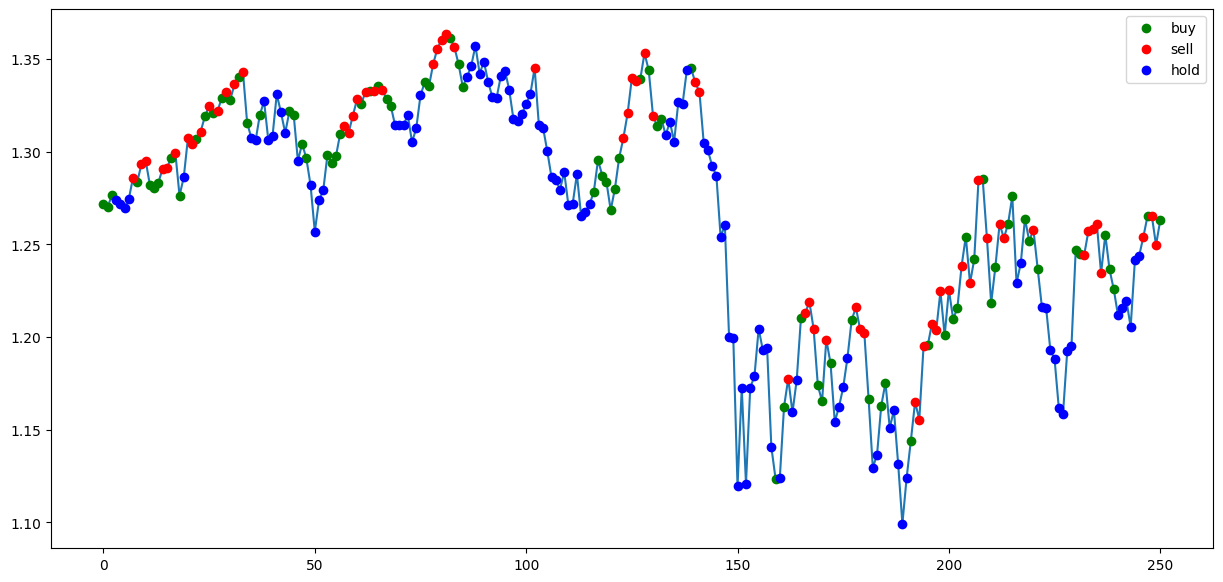

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(serie)
aux1 = np.array(serie)
aux2 = np.array(actions)

inds = np.where(aux2==0)[0]
plt.plot(inds, aux1[inds], 'og', label="buy")
inds = np.where(aux2==1)[0]
plt.plot(inds, aux1[inds], 'or', label="sell")
inds = np.where(aux2==2)[0]
plt.plot(inds, aux1[inds], 'ob', label="hold")
plt.legend();

# Conclusiones

Este modelo incluye Acciones 0 buy 1 sell 2 hold
Lim inventario 5 max y esto se controla con Estado incluye ratio/5
Penalización venta sin inv. Lo tuvimos que cambiar de -0.01 >> -1 >> -0.01 porque sino seguí intentando vender sin inventario, además hemos agregado una comisión por venta de 0.002 porque sino hiper trading, en esta simulación no lo ha intentado, posiblemente lo ha aprendido bien.
epsilon_decay 0.99 y lo hacemos linealmente hemos terminado con 200 episodios en 0.13 o sea casi no explora.
M2M Market to Market  No  (venta/compra/hold en cada step) No lo hemos implementado sería un buena intentarlo, pero no es parte del alcance de este PC. El refuerzo se le da al agente una vez ha terminado el episodio, cuando podría irlo haciendo en cada paso, pero hace el cálculo mucho más intenso. En este entrenamiento con GPU hemos tardado unas 8hs. Tipo de reward Sparse (solo al vender)
Carry cost  No hemos incluido esta variable que es algo importante, por mantener posiciones en ocasiones nos cobran.



---
**Interpretacion de gráficos:**
- Gráfico Profit vs Epsilon: Visualización de doble eje para monitorear relación exploración-explotación
Observaciones:
Patrones Positivos:
- HOLD dominante (puntos azules): El agente aprendió que "no hacer nada" es válido → evita comisiones innecesarias
- SELL en máximos (puntos rojos en peaks): Timing correcto, vende caro cuando detecta peaks locales (ej: ~índice 75, 130, 250)
- BUY en valles (puntos verdes): Algunos (pocos) bien ubicados en mínimos locales, compra barato
Problemas:
- Muy conservador: Más HOLD que operaciones activas
- Pocas compras: No capitaliza suficientes oportunidades en valles profundos (zona 150-175)
- Operaciones escasas: En 250+ días, solo ~30-40 transacciones → demasiado pasivo
- Interpretación: Agente aprendió a evitar pérdidas (defensivo) pero no maximizar ganancias (ofensivo). Es un trader novato prudente, no un trader agresivo.


- GRÁFICA 2: Profit vs Epsilon (Exploración → Explotación)
- Doble eje: Profit por episodio (azul) + Epsilon (naranja)
- Métricas Clave:
     - Profit promedio: -$2.93 (global), -$2.43 (últimos 5 episodios)
     - Epsilon inicial: 1.0 (100% exploración aleatoria)
     - Epsilon final: 0.134 (13.4% exploración residual)
     - Mejor episodio: $1.77 (episodio desconocido pero visible en gráfica)
Análisis Temporal (3 fases):
- Fase 1: Episodios 0-50 (Exploración caótica)
Profit: Pérdidas volátiles (-$3 a -$6)
Epsilon: 1.0 → ~0.6 (bajando rápido)
Comportamiento: Agente explora acciones random, aprende qué NO hacer
Resultado: Pérdidas grandes por comisiones + malas decisiones
- Fase 2: Episodios 50-100 (Transición crítica)
Profit: Mejora gradual, menos volatilidad
Epsilon: 0.6 → 0.37 (exploración moderada)
Momento clave (ep ~80, ε≈0.4): Punto de inflexión donde explotación supera exploración
Resultado: Agente encuentra estrategias que funcionan (HOLD + vender en peaks)
- Fase 3: Episodios 100-200 (Explotación estabilizada)
Profit: Oscila en rango -1 a -4 dolares, tiende a mejorar hacia el final
Epsilon: 0.37 → 0.134 (decae lentamente por ε_decay=0.99)
Picos positivos: Varios episodios con profit cercano a cero (línea azul cruza eje 0)




# Comparativa con agentes anteriores

A contiuanción tenemos los resultados del anterior Agente:
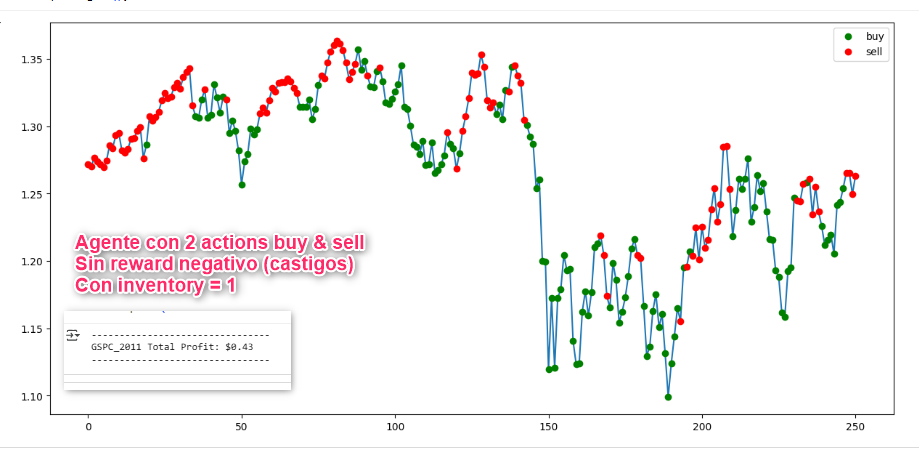

Es parecido de las gráficas es sorprendente.
Moraleja, si inviertes en bolsa, tienes que ver el largo plazo, los fundamentales de la empresa en la que inviertas y a ser posible buscar empresas que den dividentos.



*   Paso termina: si done = True, se liquidan todas las posiciones restantes al precio precio_t y se suma su ganancia/pérdida al reward final
*   La red neuronal remplaza la "tabla Q":  estima Q(s,a) para actiones de buy,sell,hold y se elige armax

Además los resultados son muy similares.
Tal vez lo que tocaría es estudiar, más factores del Entorno que puedan ser interesantes.
Existe otro Notebook que lo hace con resultados un poquito similares.


En resumen lo aprendido en este notebook a nivel Agentes:
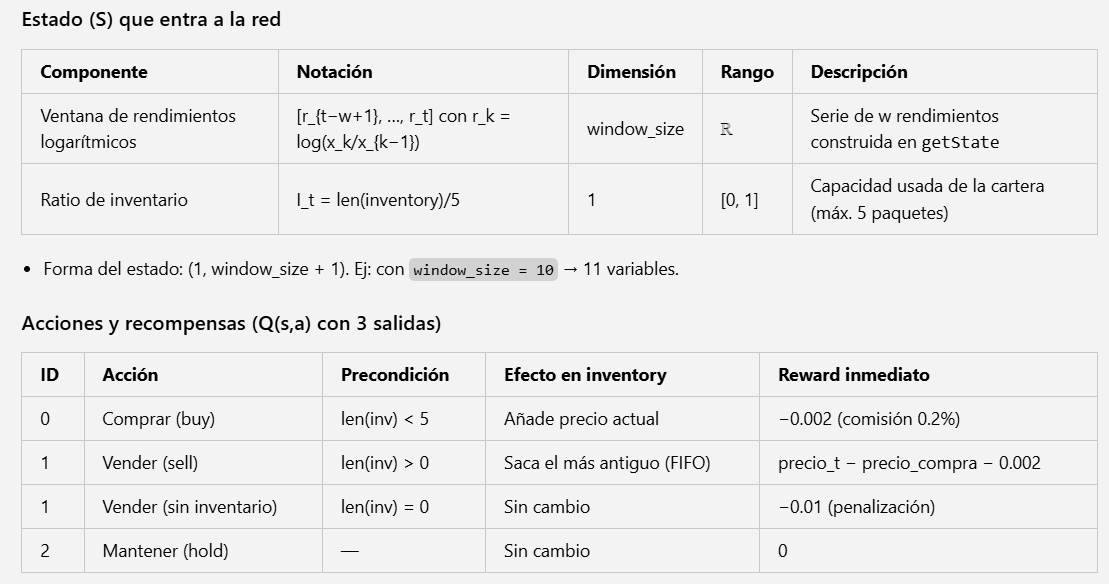

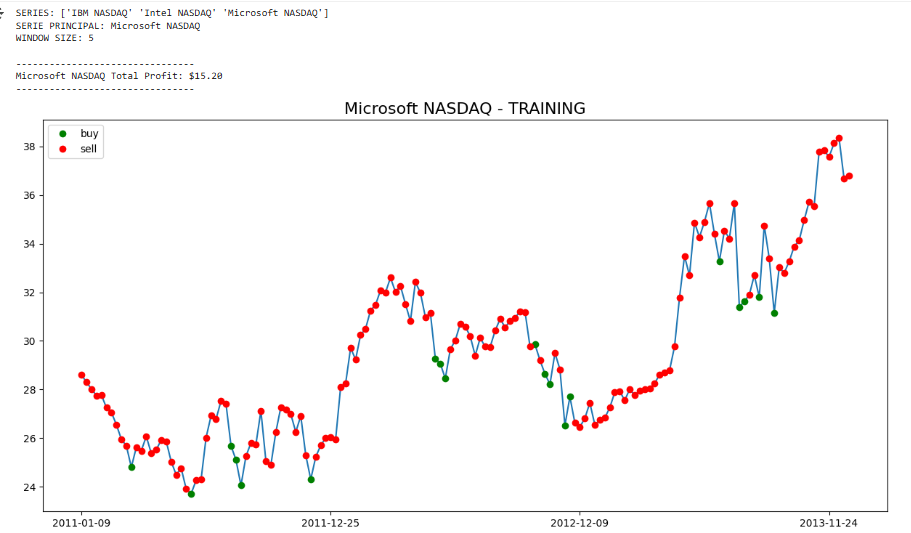

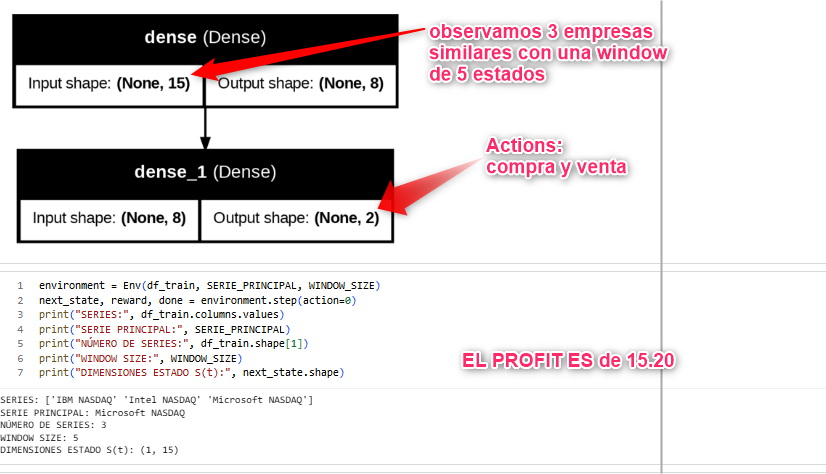

In [ ]:
# DESCONECTAR RUNTIME DE COLAB AUTOMÁTICAMENTE
# Esto liberará los recursos de GPU/TPU después de completar el entrenamiento
# IMPORTANTE: Solo descomentar si estás en Google Colab

import time
print("\n" + "="*70)
print(" El runtime de Colab se desconectará en 30 segundos...")
print("   Asegúrate de haber guardado todos los resultados importantes.")
print("   Los modelos están guardados en 'drive/MyDrive/PC5/models/'")
print("="*70)

time.sleep(30)  # Esperar 30 segundos para revisar resultados

# Desconectar runtime (solo funciona en Colab)
try:
    from google.colab import runtime
    runtime.unassign()
except:
    print(" No estás en Google Colab. El runtime no se desconectará.")


EOF